In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import pickle
import os
import scipy
import seaborn as sns
from datetime import datetime
import utils
import anndata as ad

Global seed set to 0


In [2]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

In [3]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="3"
torch.cuda.is_available()

True

In [4]:
import random

def set_random_seed(seed_value=42):
    """Set random seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using CUDA
    np.random.seed(seed_value)
    random.seed(seed_value)

# Call the function before creating your Lightning module, data module, or initializing your data loaders
set_random_seed()

# load data

In [7]:
cd45_adata = sc.read_h5ad("/localdata/rna_rep_learning/zavidij_etal/cd45_adata.h5ad")

In [7]:
#temporarily convert to more specific cell types
cd45_adata.obs.celltype = cd45_adata.obs.Tcellsubtype.astype('str').replace('nan',np.NaN).fillna(cd45_adata.obs.celltype.astype('str'))

In [8]:
#load trained scvi model
#setup data for scvi
scvi.model.SCVI.setup_anndata(cd45_adata)

with open("/localdata/rna_rep_learning/scset/scvi_data/cd45model.pkl", "rb") as f:
    fullmodel = pickle.load(f)   

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
cd45_obs = cd45_adata.obs
cd45_var = cd45_adata.var
del cd45_adata

#### 700 ish cancer genes

In [5]:
geneset1 = pd.read_csv("hallmark_genesets/HALLMARK_E2F_TARGETS.v2023.1.Hs.tsv", sep="\t")
geneset2 = pd.read_csv("hallmark_genesets/HALLMARK_G2M_CHECKPOINT.v2023.1.Hs.tsv", sep="\t")
geneset3 = pd.read_csv("hallmark_genesets/HALLMARK_KRAS_SIGNALING_UP.v2023.1.Hs.tsv", sep="\t")
geneset4 = pd.read_csv("hallmark_genesets/HALLMARK_MYC_TARGETS_V1.v2023.1.Hs.tsv", sep="\t")
geneset5 = pd.read_csv("hallmark_genesets/HALLMARK_MYC_TARGETS_V2.v2023.1.Hs.tsv", sep="\t")

cancer_genes1 = geneset1[geneset1.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes2 = geneset2[geneset2.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes3 = geneset3[geneset3.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes4 = geneset4[geneset4.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes5 = geneset5[geneset5.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()

cancer_genes = list()
cancer_genes.extend(cancer_genes1)
cancer_genes.extend(cancer_genes2)
cancer_genes.extend(cancer_genes3)
cancer_genes.extend(cancer_genes4)
cancer_genes.extend(cancer_genes5)

cancer_genes = list(set(cancer_genes))

In [6]:
len(cancer_genes)

715

In [8]:
len(np.intersect1d(cancer_genes, cd45_adata.var.index))

681

# create & save 1000 patients

In [72]:
#generate synthetic data
cell_types = ["CD4 Cytotoxic", "CD8 Cytotoxic", "Helper 1", "Memory Cytotoxic", "B-cells", "CD14+ Monocytes"]
dir_strength = 30
cell_type_dirichlet_concentrations={"CD4 Cytotoxic":0.1*dir_strength, "CD8 Cytotoxic":0.05*dir_strength, "Helper 1":0.2*dir_strength, "Memory Cytotoxic":0.2*dir_strength, "B-cells":0.2*dir_strength, "CD14+ Monocytes":0.25*dir_strength}
npatients = 1000
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
sim_counts = np.empty((np.sum(total_cells_pp), cd45_adata.shape[1]))
verbose=False

print("generating {} synthetic samples...".format(npatients))
cell_index = 0
for i in np.arange(npatients):
    if i % 100 == 0:
        print(i)
    if i <=(npatients/2-1):    
        sim_counts[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = utils.sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="unperturbed")

    else:
        sim_counts[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = utils.sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="perturbed", 
                                                                                                          celltypesperturb=["CD8 Cytotoxic"], perturbed_gene_set=cancer_genes, verbose=False)
        
    cell_index += total_cells_pp[i]
    if i==0:
        sim_metadata = joint_obs_Tsubtypes.copy()
    else: 
        sim_metadata = pd.concat([sim_metadata, joint_obs_Tsubtypes], axis=0)


generating 1000 synthetic samples...
0
100
200
300
400
500
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
600
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
700
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
800
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
900
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.


In [73]:
print("creating anndata object...")
# make anndata object for model to use
sim_adata_cd8shift = sc.AnnData(sim_counts, obs=sim_metadata, var = cd45_adata.var)
sim_adata_cd8shift.layers['counts'] = sim_adata_cd8shift.X.copy()

creating anndata object...


/tmp/ipykernel_764080/4094972545.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_adata_cd8shift = sc.AnnData(sim_counts, obs=sim_metadata, var = cd45_adata.var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [74]:
print("lognorm data...")
sc.pp.normalize_total(sim_adata_cd8shift, target_sum=1e4)
sc.pp.log1p(sim_adata_cd8shift)
sc.pp.highly_variable_genes(sim_adata_cd8shift, min_mean=0.0125, max_mean=6, min_disp=0.5)
sim_adata_cd8shift.layers['lognorm'] = sim_adata_cd8shift.X.copy()

lognorm data...


In [ ]:
sc.pp.scale(sim_adata_cd8shift, max_value=10)
sc.tl.pca(sim_adata_cd8shift, svd_solver='arpack')

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


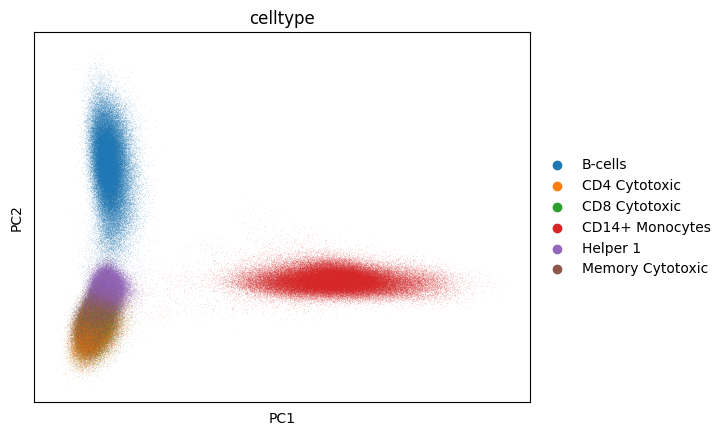

In [80]:
sc.pl.pca(sim_adata_cd8shift, color='celltype')

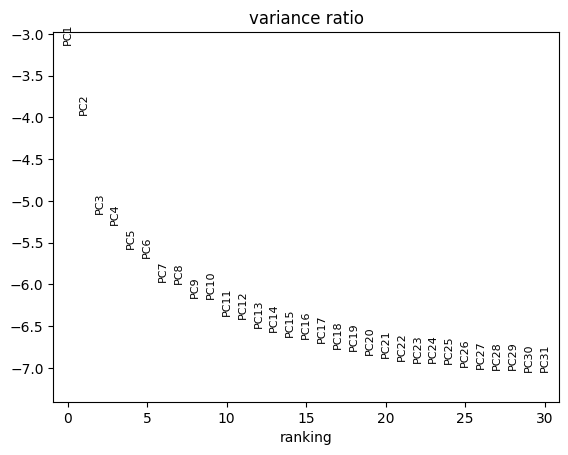

In [81]:
sc.pl.pca_variance_ratio(sim_adata_cd8shift, log=True)

In [82]:
sc.pp.neighbors(sim_adata_cd8shift, n_neighbors=10, n_pcs=20)

In [83]:
sc.tl.umap(sim_adata_cd8shift)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


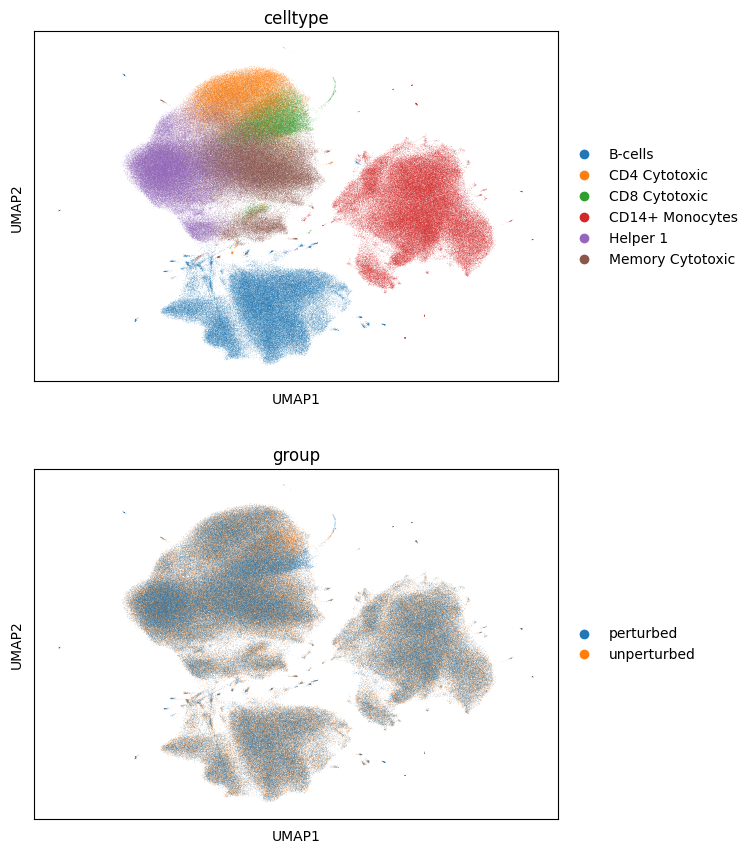

In [84]:
sc.pl.umap(sim_adata_cd8shift, color=['celltype', 'group'], ncols=1)

In [85]:
sim_adata_cd8shift.write_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_adata.h5ad")

# create & save 10k patients (must do in chunks due to memory constraints)

In [14]:
#generate synthetic data
cell_types = ["CD4 Cytotoxic", "CD8 Cytotoxic", "Helper 1", "Memory Cytotoxic", "B-cells", "CD14+ Monocytes"]
dir_strength = 30
cell_type_dirichlet_concentrations={"CD4 Cytotoxic":0.1*dir_strength, "CD8 Cytotoxic":0.05*dir_strength, "Helper 1":0.2*dir_strength, "Memory Cytotoxic":0.2*dir_strength, "B-cells":0.2*dir_strength, "CD14+ Monocytes":0.25*dir_strength}
for d in np.arange(10):

    #create 1k patients at a time
    npatients = 1000
    mean_ncells = 445
    total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
    sim_counts = np.empty((np.sum(total_cells_pp), len(cd45_var)))
    verbose=False
    
    print("iter {}: generating {} synthetic samples...".format(d+1, npatients))
    cell_index = 0
    for i in np.arange(npatients):
        pt_id = d * npatients + i
        #if i % 100 == 0:
            #print(i)
        if i <=(npatients/2-1):    
            sim_counts[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = utils.sample_pt_cells_scvi(cd45_obs, cd45_var, fullmodel, cell_types, cell_type_dirichlet_concentrations, total_cells_pp[i], ptname="sim_pt{}".format(pt_id+1), groupname="unperturbed")
    
        else:
            sim_counts[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = utils.sample_pt_cells_scvi(cd45_obs, cd45_var, fullmodel, cell_types, cell_type_dirichlet_concentrations, total_cells_pp[i], ptname="sim_pt{}".format(pt_id+1), groupname="perturbed", 
                                                                                                              celltypesperturb=["CD8 Cytotoxic"], perturbed_gene_set=cancer_genes, verbose=False)
            
        cell_index += total_cells_pp[i]
        if i==0:
            sim_metadata = joint_obs_Tsubtypes.copy()
        else: 
            sim_metadata = pd.concat([sim_metadata, joint_obs_Tsubtypes], axis=0)

    ## convert sim_counts to sparse, concat counts & metadata to previous batch
    print("iter {}: convert counts to scipy.sparse...".format(d+1))
    sim_counts = scipy.sparse.csr_matrix(sim_counts)
    
    print("iter {}: concatenating results to previous batches...".format(d+1))
    if d==0:
        full_sim_counts = sim_counts.copy()
    else:
        full_sim_counts = scipy.sparse.vstack([full_sim_counts, sim_counts])
        
    # metadata
    if d==0: 
        full_sim_metadata = sim_metadata.copy()
    else:
        full_sim_metadata = pd.concat([full_sim_metadata, sim_metadata], axis=0)


#create anndata
print("creating full anndata object...")
full_adata = sc.AnnData(full_sim_counts, obs=full_sim_metadata, var = cd45_var)
del full_sim_counts, full_sim_metadata

# save to disk just in case of crash
print("writing full anndata object...")
full_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_{}patients.h5ad".format((d+1)*npatients), compression="gzip")

iter 10: generating 1000 synthetic samples...
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
this patient doesn't have any CD8 Cytotoxic cells. skipping this cell type.
iter 10: convert counts to scipy.sparse...
iter 10: concatenating results to previous batches...
creating full anndata object...


/tmp/ipykernel_983089/788068193.py:52: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_adata_cd8shift = sc.AnnData(full_sim_counts, obs=full_sim_metadata, var = cd45_var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


writing full anndata object...


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


NameError: name 'full_adata' is not defined

In [6]:
full_adata = sc.read_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_adata_10000patients.h5ad")


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
full_adata

AnnData object with n_obs × n_vars = 4450012 × 23776
    obs: 'orig_cellbarcode', 'patient_orig', 'celltype', 'Tcellsubtype', 'group', 'patient'

In [ ]:
# lognorm, HVG
full_adata.layers['counts'] = full_adata.X.copy()

print("lognorm data...")
sc.pp.normalize_total(full_adata, target_sum=1e4)
sc.pp.log1p(full_adata)
full_adata.layers['lognorm'] = full_adata.X.copy()

In [9]:
print("compute HVG...")
sc.pp.highly_variable_genes(full_adata, layer="counts", flavor='seurat_v3', n_top_genes=5000)

compute HVG...


In [10]:
d=9
npatients=1000

In [11]:
# save to disk just in case of crash
print("writing full anndata object...")
full_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_{}_patients.h5ad".format((d+1)*npatients), compression="gzip")

writing full anndata object...


In [14]:
# create a version of the anndata just with HVG, for slower preprocessing stepes
hvg_adata = full_adata[:,full_adata.var.highly_variable]#.write_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_10000patients_HVGonly.h5ad")#.format((d+1)*npatients), compression="gzip")
del full_adata

scale data...


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


compute PCA...


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


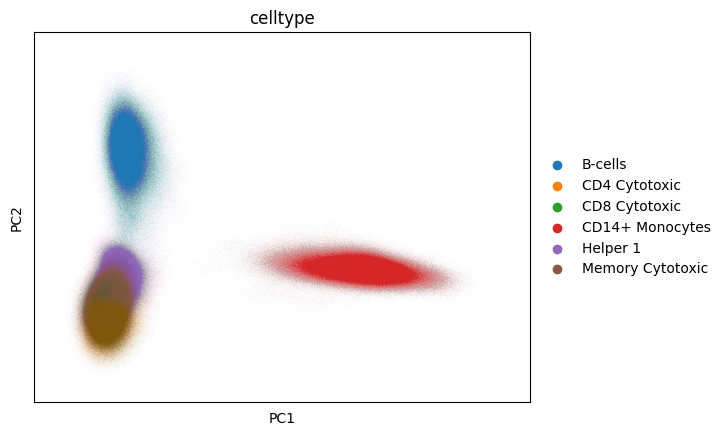

In [19]:
print("scale data...")
sc.pp.scale(hvg_adata, max_value=10)

print("compute PCA...")
sc.tl.pca(hvg_adata, svd_solver='arpack')
sc.pl.pca(hvg_adata, color='celltype')

In [23]:
#save to disk 
print("writing HVG subsetted, pre-processed (lognorm, pca) anndata object to disk...")
hvg_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_{}_patients_HVGonly.h5ad".format((d+1)*npatients), compression="gzip")
       

writing HVG subsetted, pre-processed (lognorm, pca) anndata object to disk...


In [16]:
hvg_adata = sc.read_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_10000_patients_HVGonly_scGPT.h5ad")


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [1]:
# havent run this yet, kernel died

sc.pp.neighbors(hvg_adata, n_neighbors=10, n_pcs=20)

sc.tl.umap(hvg_adata)

sc.pl.umap(hvg_adata, color=['celltype', 'group'], ncols=1)

#save to disk 
print("writing HVG subsetted, pre-processed (umap) anndata object to disk...")
hvg_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_{}_patients_HVGonly_scGPT.h5ad".format((d+1)*npatients), compression="gzip")
   

NameError: name 'sc' is not defined